# **Практическая работа №8. Генеративно-состязательная сеть (GAN). Часть 1**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1i3NlGFJbY6hvm-ropSFobW9_nqUcqzPS?usp=sharing)

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

Взят датасет отсюда:
https://www.kaggle.com/datasets/tatianasnwrt/russian-handwritten-letters

In [58]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from imutils import paths
import random 
import cv2

In [59]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

## Конструктор генератора

In [100]:
def build_generator():
    noise_shape = (100,)

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    noise = Input(shape=noise_shape)
    img = model(noise)    # Генерация изображения

    return Model(noise, img)

## Конструктор дискриминатора

In [101]:
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='relu'))

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

### Функции для сохранения и загрузки

In [102]:
from tensorflow.keras.models import load_model, save_model
import os

models_path = r'model'
gan_path = models_path + '\\' + "gan"
generator_path = models_path + '\\' + "generator"
discriminator_path = models_path + '\\' + "discriminator"

Path(gan_path).mkdir(parents=True, exist_ok=True)
Path(generator_path).mkdir(parents=True, exist_ok=True)
Path(discriminator_path).mkdir(parents=True, exist_ok=True)

def save(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, gan_path)
    discriminator.trainable = True
    save_model(generator, generator_path)
    save_model(discriminator, discriminator_path)

def load():
    discriminator = load_model(discriminator_path)
    generator = load_model(generator_path)
    gan = load_model(gan_path)
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [104]:
# X_train = np.load('mnist_imgs.npy')
(X_train, _), (_, _) = mnist.load_data()
#X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.astype(np.float32) / 255.0
img_shape = (28, 28, 1)

In [105]:
print(X_train.shape)
print(np.max(X_train[0]))
print(np.min(X_train[0]))

(60000, 28, 28)
1.0
0.0


In [108]:
discriminator = build_discriminator()
discriminator.trainable = False
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.00001, 0.5), metrics=['accuracy'])
discriminator.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 sequential_15 (Sequential)  (None, 1)                 533505    
                                                                 
Total params: 533,505
Trainable params: 0
Non-trainable params: 533,505
_________________________________________________________________


In [110]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))
generator.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_17 (Sequential)  (None, 28, 28, 1)         1493520   
                                                                 
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________


In [111]:
z = Input(shape=(100,))
img = generator(z)

valid = discriminator(img)  #Проверка достоверности сгенерированного изображения

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.00002, 0.5))
combined.trainable = True
combined.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 100)]             0         
                                                                 
 model_23 (Functional)       (None, 28, 28, 1)         1493520   
                                                                 
 model_21 (Functional)       (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 2,023,441
Non-trainable params: 3,584
_________________________________________________________________


In [112]:
def train(epochs, batch_size=128, save_interval=50):
    half_batch = int(batch_size / 2)
    progress = tqdm(total=epochs)
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
 
        noise = np.random.normal(0, 1, (half_batch, 100))

        gen_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        noise = np.random.normal(0, 1, (batch_size, 100)) 

        valid_y = np.array([1] * batch_size)
        g_loss = combined.train_on_batch(noise, valid_y)


        # Дополнительно, чтобы мы могли отслеживать процесс обучения, мы выводим на печать
        # прогресс и сохраняем вывод образцов изображений в зависимости от заданного интервала эпох, 
        # а также по желанию, можем сохранять модель.  
        status = "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)
        progress.set_description_str(status)
        progress.update(1)

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            progress.write("Saving images...")
            save_imgs(epoch)
            if epoch % 1000 == 0:
                # save(combined, generator, discriminator)
                progress.write("Saving models...")
                save(combined, generator, discriminator)



In [113]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
            
    Path('gen_images').mkdir(parents=True, exist_ok=True)
    fig.savefig('gen_images' + '\\' + f'epoch_{epoch}.png')
    plt.close()

In [115]:
train(epochs=25000, batch_size=256, save_interval=2000)

generator.save('generator_model_final_4.h5')

  0%|          | 0/25000 [00:00<?, ?it/s]

Saving images...
1/1 [==============================] - 0s 29ms/step
Saving models...
INFO:tensorflow:Assets written to: model\gan\assets
INFO:tensorflow:Assets written to: model\generator\assets
INFO:tensorflow:Assets written to: model\discriminator\assets
Saving images...
1/1 [==============================] - 0s 32ms/step
Saving models...
INFO:tensorflow:Assets written to: model\gan\assets
INFO:tensorflow:Assets written to: model\generator\assets
INFO:tensorflow:Assets written to: model\discriminator\assets
Saving images...
1/1 [==============================] - 0s 28ms/step
Saving models...
INFO:tensorflow:Assets written to: model\gan\assets
INFO:tensorflow:Assets written to: model\generator\assets
INFO:tensorflow:Assets written to: model\discriminator\assets


KeyboardInterrupt: 

In [117]:
half_batch = int(256 / 2)
noise = np.random.normal(0, 1, (half_batch, 100))

gen_imgs = generator.predict(noise, verbose=0)

In [132]:
discriminator.predict(gen_imgs[0])

1/1 [==============================] - 0s 75ms/step


array([[1.9168278]], dtype=float32)

In [128]:
#plt.figure()
#plt.imshow(noise, cmap='gray')

noise.shape

(128, 100)

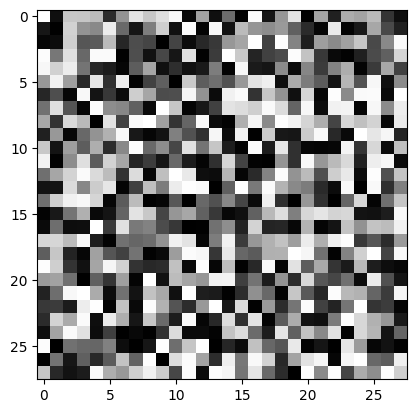

In [123]:
plt.figure()
plt.imshow(gen_imgs[0], cmap='gray')

### Демонстрация сгенерированных изображений:

# **Задание №2.** Обучите генератор воспризводить сложные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/fedesoriano/cifar100))

In [ ]:
https://www.kaggle.com/datasets/fedesoriano/cifar100# Ваш код

### Демонстрация сгенерированных изображений:

In [ ]:
# Ваш код